## PREPROCECING BASE DE DADES

Carreguem paquests necessaris:

In [14]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
import random
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Prova per a carregar una imatge qualsevol i observar-ne el format i les dimensions, per tal de que sigui correcte.

In [4]:
# load the image
image = Image.open('Mushrooms/Agaricus/0.jpg').convert('RGB')
# summarize some details about the image
print(image.format)
print(image.mode)
print(image.size)

None
RGB
(778, 600)


Com era d'esperar les dimencions de les imatges són extremadament grans, s'hauràn de reduir per tal de poder executar
sense problemes el script.

### Creació de la base de dades

Les dimencions ajustades a cada imatge són de 50x50 ja que així l'executació és més ràpida i per falta d'espai. Si és possible, més endevant s'augmentaràn aquestes mètriques.

In [5]:
IMG_WIDTH=50
IMG_HEIGHT=50

La següent funció primer llegeix les imatges de cada respectiva carpeta, el nom de la qual és el label de cada imatge. 
Tot seguit ajusta cada imatge a les dimencions especificades anteriorment, passa cada imatge a array i les normalitza.
Finalment, guarda en un array els labels i en un altre les imatges.

In [6]:
def create_dataset(img_folder):
    
    img_data_array=[]
    class_name=[]
    
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path = os.path.join(img_folder, dir1,  file)
            image = np.array(Image.open(image_path).convert('RGB').resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS))
            img_data = image.astype('float32')
            img_data /= 255 
            img_data_array.append(img_data)
            class_name.append(dir1)
   
    return img_data_array , class_name

In [7]:
img_folder=r'Mushrooms'
img_data, class_name=create_dataset(img_folder)

Passem les imatges de 'list' a 'array' per tal de treballar les dades més fàcilment i observem dimencions.

In [8]:
img_data=np.array(img_data)
img_data.shape

(9272, 50, 50, 3)

Creem un diccionari per codificar cada label de cada imatge i diferenciar cada classe de forma numerica. Tot seguit, creem la variable 'target_val' que serà el array dels labels recodificat.

In [9]:
target_dict={k: v for v, k in enumerate(np.unique(class_name))}
target_dict

{'Agaricus': 0,
 'Amanita': 1,
 'Boletus': 2,
 'Cortinarius': 3,
 'Entoloma': 4,
 'Exidia': 5,
 'Hygrocybe': 6,
 'Inocybe': 7,
 'Lactarius': 8,
 'Pluteus': 9,
 'Russula': 10,
 'Suillus': 11}

In [10]:
target_val=  [target_dict[class_name[i]] for i in range(len(class_name))]
target_val=np.array(target_val)

#### Observem imatges per pantalla

In [11]:
def plot_examples(images, labels, labels_text, nrows=2):
    n_examples = images.shape[0]
    ncols = np.ceil(n_examples / nrows).astype(np.int)

    fig, ax = plt.subplots(nrows, ncols, figsize=(2*ncols, 2*nrows), squeeze=False)
    for i in range(n_examples):
        ax[i // ncols, i % ncols].imshow(images[i], cmap="gray")
        ax[i // ncols, i % ncols].set_title("{}".format(labels_text[labels[i]]))
        ax[i // ncols, i % ncols].axis("off")

Observem una imatge aleatoria de cada espècie amb el seu label correxponent.

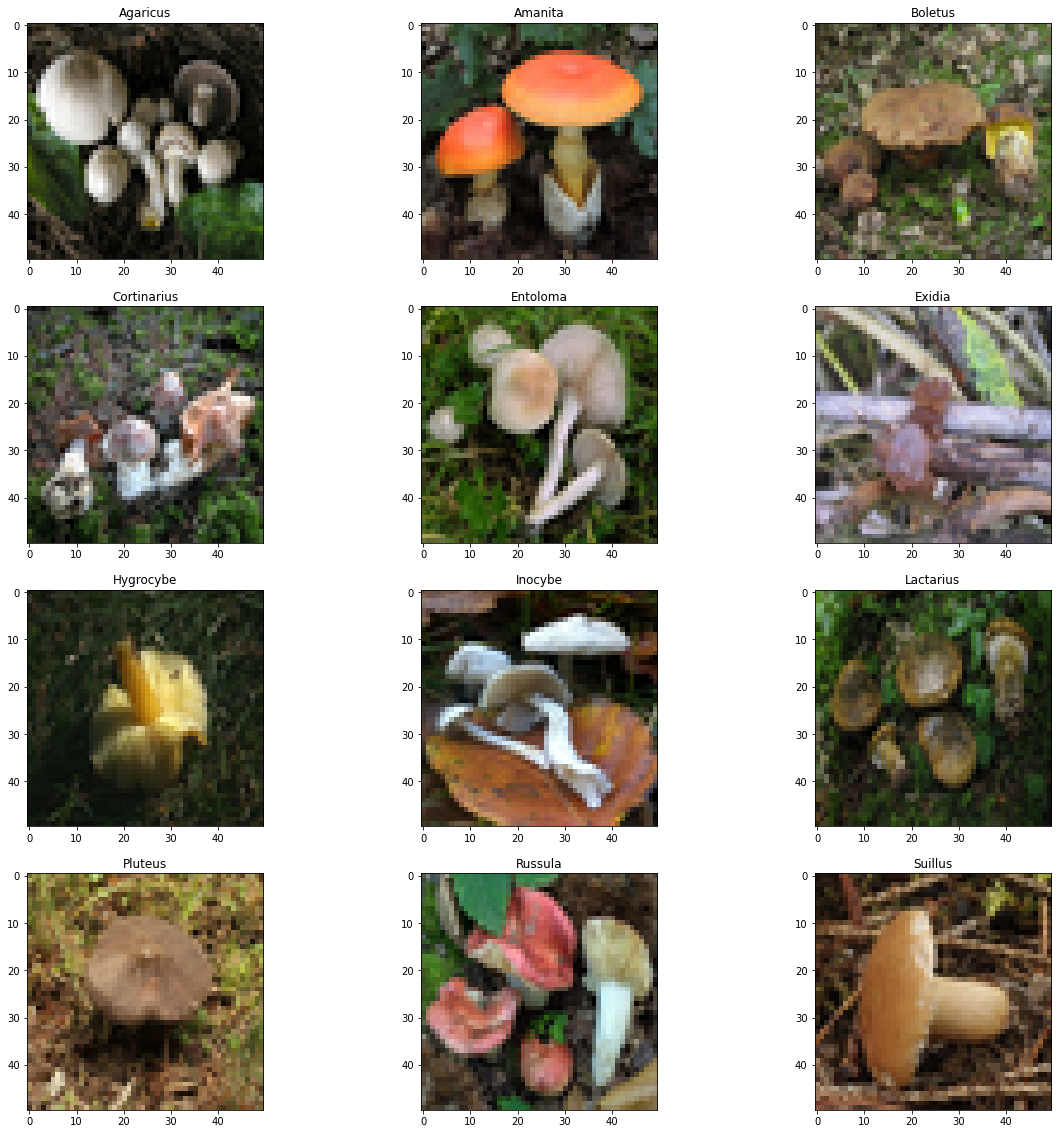

In [12]:
plt.figure(figsize=(20,20))

n_classes=len(target_dict)

for i in range(n_classes):
    idxs = np.random.choice(np.where(target_val == i)[0])
    
    ax=plt.subplot(4,3,i+1)
    ax.title.set_text(class_name[idxs])
    plt.imshow(img_data[idxs])

## Train - Validation - Test split

Separem el dataset en tres parts: una part 'train' (80% aproximat de les imatges), una part 'validation' (10% aproximat de les imatges) i una part 'test' (10% aproximat de les imatges).

In [15]:
train_img, test_img, train_labels, test_labels = train_test_split(img_data, target_val,test_size=0.2,random_state=8)
test_img,validation_img,test_labels,validation_labels = train_test_split(test_img,test_labels,test_size=0.5,random_state=8)
print('Train data shape : ', train_img.shape, train_labels.shape)
print('Validation data shape : ', validation_img.shape, validation_labels.shape)
print('Testing data shape : ', test_img.shape, test_labels.shape)

Train data shape :  (7417, 50, 50, 3) (7417,)
Validation data shape :  (928, 50, 50, 3) (928,)
Testing data shape :  (927, 50, 50, 3) (927,)


### CREACIÓ CNN

La següent xarxa neuronal convolucional està creada a partir d'un exemple fet a classe, cal modificar cada layer si cal i es pot millorar.

In [24]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH,IMG_HEIGHT, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(12,activation='softmax'))


In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 5184)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

Ajustem la CNN a les dades d'entrenament i l'entrenem:

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_img,train_labels, epochs=20,validation_data=(validation_img,validation_labels))

Epoch 1/20
232/232 [==============================] - 23s 96ms/step - loss: 2.4035 - accuracy: 0.1434 - val_loss: 2.2002 - val_accuracy: 0.2360
Epoch 2/20
232/232 [==============================] - 20s 87ms/step - loss: 2.1533 - accuracy: 0.2587 - val_loss: 2.0160 - val_accuracy: 0.3265
Epoch 3/20
232/232 [==============================] - 20s 87ms/step - loss: 1.9641 - accuracy: 0.3287 - val_loss: 1.9348 - val_accuracy: 0.3470
Epoch 4/20
232/232 [==============================] - 21s 90ms/step - loss: 1.8208 - accuracy: 0.3927 - val_loss: 1.8324 - val_accuracy: 0.3858
Epoch 5/20
232/232 [==============================] - 23s 101ms/step - loss: 1.6370 - accuracy: 0.4501 - val_loss: 1.9067 - val_accuracy: 0.3750
Epoch 6/20
232/232 [==============================] - 24s 104ms/step - loss: 1.4789 - accuracy: 0.4980 - val_loss: 1.7918 - val_accuracy: 0.4073
Epoch 7/20
232/232 [==============================] - 26s 111ms/step - loss: 1.2673 - accuracy: 0.5647 - val_loss: 1.8687 - val_accura

### TEST VALIDATION

29/29 - 1s - loss: 5.1051 - accuracy: 0.4293


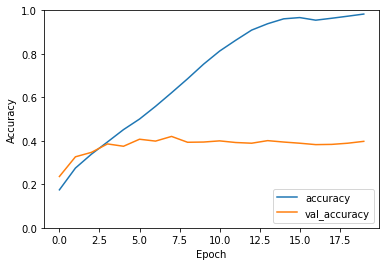

In [27]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_img,  test_labels, verbose=2)

In [28]:
print(test_acc)

0.42934197187423706
